In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import math

# TEST ASSUMPTIONS
import statsmodels.stats.api as sms # homoskedasticity
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white # homoskedasticity
from scipy.stats import bartlett # homoskedasticity
from scipy.stats import normaltest # for normal distribution
from statsmodels.stats import diagnostic as diag # autocorellation (not so important)
import statsmodels.api as sm # autocorellation (not so important)

# LASSO model selection
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso

# CREATED FUNCTIONS
from ufc_func import *

# OUTLIERS
from scipy import stats

In [2]:
df = pd.read_csv("./ufc.csv")
df = pd.DataFrame(df)
df

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412,"Denver, Colorado, USA",Orlando Wiet,Sean Daugherty,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:20,UFC 2,11-Mar-94,Patrick Smith
7413,"Denver, Colorado, USA",Frank Hamaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scott Morris
7414,"Denver, Colorado, USA",Johnny Rhodes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7415,"Denver, Colorado, USA",Patrick Smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Our dataframe contains some null rows, so will need to remove it. Additionally column with "Time" doesn't useful for our aims in this represantation. We need to convert it to another units (to seconds).

In [3]:
df = df.dropna()
df_with_time = df.copy()

df_with_time["Seconds"] = df_with_time["Time"].apply(time_converter) + df_with_time["Round"].apply(round_converter)
df_with_time


,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan,64.0
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner,169.0
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo,900.0
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady,703.0
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7408,"Denver, Colorado, USA",Patrick Smith,Robert Lucarelli,0.0,0.0,8.0,2.0,0.0,1.0,0.0,1.0,Open Weight,KO/TKO,1.0,2:50,UFC 2,11-Mar-94,Remco Pardoel,170.0
7409,"Denver, Colorado, USA",Royce Gracie,Thaddeus Luster,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,Open Weight,SUB Keylock,1.0,4:52,UFC 2,11-Mar-94,Orlando Wiet,292.0
7410,"Denver, Colorado, USA",Jason DeLucia,David Levicki,0.0,0.0,11.0,4.0,1.0,0.0,0.0,0.0,Open Weight,KO/TKO Punches,1.0,12:13,UFC 2,11-Mar-94,Frank Hamaker,733.0
7411,"Denver, Colorado, USA",Remco Pardoel,Ray Wizard,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:58,UFC 2,11-Mar-94,Johnny Rhodes,58.0


Also some there are some "strange" fights: fighter 1 and fighter 2 both loss in fight.

In [4]:
df_with_time.tail(10)

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
7403,"Denver, Colorado, USA",Royce Gracie,Fred Ettish,1.0,0.0,13.0,4.0,0.0,0.0,1.0,0.0,Open Weight,SUB Bulldog Choke,1.0,3:07,UFC 2,11-Mar-94,Remco Pardoel,187.0
7404,"Denver, Colorado, USA",Patrick Smith,Scott Morris,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,Open Weight,KO/TKO Elbows,1.0,0:30,UFC 2,11-Mar-94,Johnny Rhodes,30.0
7405,"Denver, Colorado, USA",Royce Gracie,Minoki Ichihara,0.0,0.0,2.0,3.0,1.0,0.0,2.0,0.0,Open Weight,SUB Armbar,1.0,5:08,UFC 2,11-Mar-94,Patrick Smith,308.0
7406,"Denver, Colorado, USA",Remco Pardoel,Scott Baker,0.0,0.0,3.0,0.0,0.0,1.0,5.0,0.0,Open Weight,SUB Triangle Choke,1.0,6:41,UFC 2,11-Mar-94,Royce Gracie,401.0
7407,"Denver, Colorado, USA",Johnny Rhodes,Alberta Cerra Leon,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,Open Weight,SUB Ezekiel Choke,1.0,9:51,UFC 2,11-Mar-94,Jason DeLucia,591.0
7408,"Denver, Colorado, USA",Patrick Smith,Robert Lucarelli,0.0,0.0,8.0,2.0,0.0,1.0,0.0,1.0,Open Weight,KO/TKO,1.0,2:50,UFC 2,11-Mar-94,Remco Pardoel,170.0
7409,"Denver, Colorado, USA",Royce Gracie,Thaddeus Luster,0.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,Open Weight,SUB Keylock,1.0,4:52,UFC 2,11-Mar-94,Orlando Wiet,292.0
7410,"Denver, Colorado, USA",Jason DeLucia,David Levicki,0.0,0.0,11.0,4.0,1.0,0.0,0.0,0.0,Open Weight,KO/TKO Punches,1.0,12:13,UFC 2,11-Mar-94,Frank Hamaker,733.0
7411,"Denver, Colorado, USA",Remco Pardoel,Ray Wizard,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:58,UFC 2,11-Mar-94,Johnny Rhodes,58.0
7412,"Denver, Colorado, USA",Orlando Wiet,Sean Daugherty,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,Open Weight,SUB Guillotine Choke,1.0,0:20,UFC 2,11-Mar-94,Patrick Smith,20.0


We need to remove it

In [5]:
df_with_time = df_with_time.loc[
    (df_with_time["Fighter 1"] == df_with_time["Winner"]) | 
    (df_with_time["Fighter 1"] == df_with_time["Winner"])].reset_index(drop=True)

Next, let us show average statistic per fight (including first and second fighter)

In [6]:
total_kd = (df["Fighter_1_KD"] + df["Fighter_2_KD"]).mean()
total_str= (df["Fighter_1_STR"] + df["Fighter_2_STR"]).mean()
total_td= (df["Fighter_1_TD"] + df["Fighter_2_TD"]).mean()
total_sub= (df["Fighter_1_SUB"] + df["Fighter_1_SUB"]).mean()

print("Average knockdowns per fight: ", total_kd)
print("Average significant strikes per fight: ", total_str)
print("Average takedown attemps per fight: ", total_td)
print("Average submissions attemps per fight: ", total_sub)

Average knockdowns per fight:  0.4305180787911495
Average significant strikes per fight:  71.68497031840259
Average takedown attemps per fight:  2.1184565569347007
Average submissions attemps per fight:  1.0642201834862386


As we can see knockdowns is the rarest fight moment. Now let us look what type of finishes UFC fight can have:

In [7]:
methods = df_with_time["Method"].unique()

methods

array(['KO/TKO Punch', 'KO/TKO Punches', 'U-DEC', 'SUB Kimura',
       'SUB Rear Naked Choke', 'KO/TKO Slam', 'S-DEC', 'SUB Neck Crank',
       'SUB Guillotine Choke', 'Overturned', 'KO/TKO Elbows',
       'KO/TKO Kick', 'SUB Armbar', 'M-DEC', 'KO/TKO Knees', 'CNC',
       'SUB Arm Triangle', 'KO/TKO Kicks', 'KO/TKO Knee', 'KO/TKO', 'DQ',
       'SUB Anaconda Choke', 'SUB Ezekiel Choke', 'SUB Triangle Choke',
       'SUB Twister', 'SUB Triangle Armbar', "SUB D'Arce Choke",
       'KO/TKO Spinning Back Elbow', 'Overturned Guillotine Choke',
       'KO/TKO Elbow', 'SUB Other - Lock', 'SUB Kneebar',
       'SUB Inverted Triangle', 'KO/TKO Flying Knee',
       'KO/TKO Spinning Back Kick', 'SUB Von Flue Choke',
       'KO/TKO Spinning Back Fist', 'SUB Keylock', 'SUB Scarf Hold',
       'SUB Straight Armbar', 'SUB Heel Hook', 'Overturned Punches',
       'SUB Ankle Lock', 'SUB Forearm Choke', 'SUB Injury',
       'Overturned Punch', 'Overturned Rear Naked Choke',
       'Overturned Knee', 'O

There are lots of different type of finishes, but all them come down to KO/TKO, SUB, DEC, CNC. Overturned, Other and DQ are useless characteristic for our research.

In [8]:
df_fil = methods_destroyer(df_with_time)

df_fil["Method"].unique()

array(['KO/TKO Punch', 'KO/TKO Punches', 'U-DEC', 'SUB Kimura',
       'SUB Rear Naked Choke', 'KO/TKO Slam', 'S-DEC', 'SUB Neck Crank',
       'SUB Guillotine Choke', 'KO/TKO Elbows', 'KO/TKO Kick',
       'SUB Armbar', 'M-DEC', 'KO/TKO Knees', 'CNC', 'SUB Arm Triangle',
       'KO/TKO Kicks', 'KO/TKO Knee', 'KO/TKO', 'SUB Anaconda Choke',
       'SUB Ezekiel Choke', 'SUB Triangle Choke', 'SUB Twister',
       'SUB Triangle Armbar', "SUB D'Arce Choke",
       'KO/TKO Spinning Back Elbow', 'KO/TKO Elbow', 'SUB Kneebar',
       'SUB Inverted Triangle', 'KO/TKO Flying Knee',
       'KO/TKO Spinning Back Kick', 'SUB Von Flue Choke',
       'KO/TKO Spinning Back Fist', 'SUB Keylock', 'SUB Scarf Hold',
       'SUB Straight Armbar', 'SUB Heel Hook', 'SUB Ankle Lock',
       'SUB Forearm Choke', 'SUB Injury', 'SUB Peruvian Necktie',
       'SUB Schultz Front Headlock', 'SUB Bulldog Choke',
       'SUB Suloev Stretch', 'SUB Omoplata', 'SUB Calf Slicer',
       'SUB North-South Choke', 'SUB Pac

Now this data can be useful, we can plot distribution of methods if we remove additional information, like "Armbar", "Punch" and so on.

In [9]:
df_methods = df_fil.copy()
df_methods["Method"] = df_fil["Method"].apply(replace_method)
df_methods["Method"].unique()

array(['KO/TKO', 'DEC', 'SUB'], dtype=object)

Now we can plot histogram of distribtuion

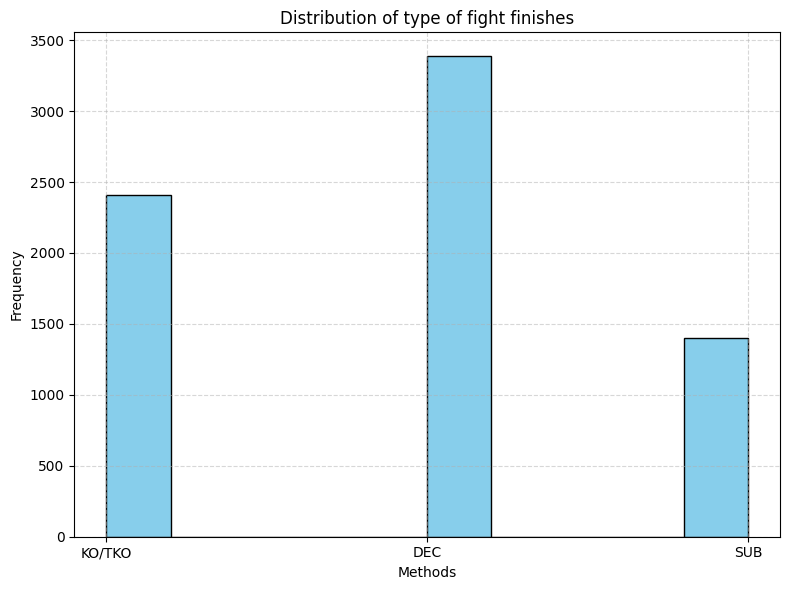

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(df_methods["Method"], color='skyblue', edgecolor='black')
plt.title('Distribution of type of fight finishes')
plt.xlabel('Methods')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Now let us take a look at "Weight_Class".

In [11]:
df_fil["Weight_Class"].unique()

array(['Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       "Women's Bantamweight", 'Light Heavyweight', "Women's Flyweight",
       "Women's Strawweight", 'Featherweight', 'Heavyweight', 'Flyweight',
       'Catch Weight', "Women's Featherweight", 'Super Heavyweight',
       'Open Weight'], dtype=object)

Some of these categories are not used in UFC, so we will drop them 

In [12]:
df_fil = weight_destroyer(df_fil)
df_fil["Weight_Class"].unique()

array(['Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       "Women's Bantamweight", 'Light Heavyweight', "Women's Flyweight",
       "Women's Strawweight", 'Featherweight', 'Heavyweight', 'Flyweight',
       "Women's Featherweight"], dtype=object)

Now it will be good to remove 5 rounds fight (championship fightr), because it has low fraction in all data, and it will make our model for prediction fight duration more bias.

In [13]:
three, five = df_breaker_by_rounds(df_fil)

df_fil = three.copy()

df_fil

,Location,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Weight_Class,Method,Round,Time,Event Name,Date,Winner,Seconds
0,"Austin, Texas, USA",Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punch,1.0,1:04,UFC Fight Night,2-Dec-23,Arman Tsarukyan,64.0
1,"Austin, Texas, USA",Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,Lightweight,KO/TKO Punches,1.0,2:49,UFC Fight Night,2-Dec-23,Jalin Turner,169.0
2,"Austin, Texas, USA",Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,Bantamweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Deiveson Figueiredo,900.0
3,"Austin, Texas, USA",Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,Welterweight,SUB Kimura,3.0,1:43,UFC Fight Night,2-Dec-23,Sean Brady,703.0
4,"Austin, Texas, USA",Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,Lightweight,U-DEC,3.0,5:00,UFC Fight Night,2-Dec-23,Joaquim Silva,900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,"Mobile, Alabama, USA",Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,Middleweight,S-DEC,2.0,3:00,UFC 17,15-May-98,Dan Henderson,480.0
7263,"Mobile, Alabama, USA",David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,Heavyweight,KO/TKO Punches,1.0,0:43,UFC 17,15-May-98,David Abbott,43.0
7264,"Mobile, Alabama, USA",Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,Heavyweight,SUB Keylock,1.0,11:01,UFC 17,15-May-98,Mike van Arsdale,661.0
7265,"Mobile, Alabama, USA",Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,Middleweight,SUB Triangle Choke,1.0,0:52,UFC 17,15-May-98,Carlos Newton,52.0


Now, we are going to remove all unneccassary columns: Date (data doesn't depend on date), Event Name, Round, Time, Location.

In [14]:
df_fil = de_remover(df_fil)

Now it will be good to remove 5 rounds fight (championship fightr), because it has low fraction in all data, and it will make our model for prediction fight duration more bias.

Finally, our dataframe is ready to be used in project. But before, we will run logit and OLS models, let us create dataframe with fighters statistic.

In [15]:
fighters = list(set(df_fil["Fighter 1"].unique()).union(set(df_fil["Fighter 2"].unique())))
fighters_df = pd.DataFrame({"Fighter_name": [],
                            "Average_significant_strikes": [],
                            "Average_takedowns": [],
                            "Average_submission_attempts": [],
                            "Average_knockdowns": [],
                            "Average_activity": [],
                            "Wins": [],
                            "Loss": [],
                            "Winrate": []})


for ele in fighters:
    win_df = df_fil.loc[df_fil["Fighter 1"] == ele]
    lose_df = df_fil.loc[df_fil["Fighter 2"] == ele]

    wins, losses = int(len(win_df.index)), int(len(lose_df.index))

    amount_of_mentions = wins + losses

    avg_strk = round((win_df["Fighter_1_STR"].sum() + lose_df["Fighter_2_STR"].sum())/amount_of_mentions, 2)
    avg_tkd = round((win_df["Fighter_1_TD"].sum() + lose_df["Fighter_2_TD"].sum())/amount_of_mentions, 2)
    avg_subs = round((win_df["Fighter_1_SUB"].sum() + lose_df["Fighter_2_SUB"].sum())/amount_of_mentions, 2)
    avg_kd = round((win_df["Fighter_1_KD"].sum() + lose_df["Fighter_2_KD"].sum())/amount_of_mentions, 2)
    # weight_class = pd.concat([lose_df["Weight_Class"], win_df["Weight_Class"]])

    avg_act = avg_strk + avg_tkd + avg_subs + avg_kd

    data = {
        "Fighter_name": [ele],
        "Average_significant_strikes": [avg_strk],
        "Average_takedowns": [avg_tkd],
        "Average_submission_attempts": [avg_subs],
        "Average_knockdowns": [avg_kd],
        "Average_activity": [avg_act],
        "Wins": [wins],
        "Loss": [losses],
        "Winrate": [round(wins/(wins+losses), 2)],
        # "Weight_class": [weight_class.unique()]
    }

    fighters_df = pd.concat([fighters_df, pd.DataFrame(data)], ignore_index = True)

fighters_df

,Fighter_name,Average_significant_strikes,Average_takedowns,Average_submission_attempts,Average_knockdowns,Average_activity,Wins,Loss,Winrate
0,Guy Mezger,2.00,0.00,3.00,0.00,5.00,0.0,1.0,0.00
1,Jake Ellenberger,19.86,1.10,0.19,0.52,21.67,10.0,11.0,0.48
2,Steven Koslow,11.00,5.00,1.00,0.00,17.00,0.0,1.0,0.00
3,Taila Santos,43.33,2.00,1.00,0.50,46.83,4.0,2.0,0.67
4,Justin Levens,1.00,0.00,0.50,0.00,1.50,0.0,2.0,0.00
...,...,...,...,...,...,...,...,...,...
2308,David Bielkheden,13.67,2.33,0.00,0.00,16.00,1.0,2.0,0.33
2309,Mike Pyle,20.16,0.84,0.74,0.21,21.95,10.0,9.0,0.53
2310,Robert Sanchez,6.67,1.67,0.33,0.00,8.67,1.0,2.0,0.33
2311,Sean Spencer,57.00,0.12,0.00,0.38,57.50,3.0,5.0,0.38


In [16]:
fighters_df = pd.read_csv("./app/data/fighter.csv")

fighters_df = pd.DataFrame(fighters_df)

fighter_weight = fighters_df[fighters_df["Weight_class"].apply(lambda x: "Welterweight" in x)].reset_index(drop=True)

fighter_weight['Fighter_name'].to_list()

['Alexander Yakovlev',
 'Rodrigo de Lima',
 'Sean Spencer',
 'Nathan Coy',
 'Ryan McGillivray',
 'Yancy Medeiros',
 'Mike Rhodes',
 'Shavkat Rakhmonov',
 'Darrius Flowers',
 'Josh Neer',
 'John Howard',
 'Dan Stittgen',
 'Che Mills',
 'Hernani Perpetuo',
 'Sean Brady',
 'Adrian Serrano',
 'John Alessio',
 'Francisco Trinaldo',
 'James Head',
 'Chris Wilson',
 'Tom Breese',
 'Marcio Alexandre Junior',
 'Wendell Oliveira Marques',
 'Jon Manley',
 'Chris Brennan',
 'Stephen Thompson',
 'Bojan Velickovic',
 'Ben Alloway',
 'Matthew Riddle',
 'Ramsey Nijem',
 'Rostem Akman',
 'Rafael Dos Anjos',
 'Zak Ottow',
 'Brandon Thatch',
 'Clay Harvison',
 'Ricardo Almeida',
 'Rich Attonito',
 'Kyle Noke',
 'Lyman Good',
 'Matt Brown',
 'Amir Sadollah',
 'Alex Morono',
 'Joe Stevenson',
 'Khamzat Chimaev',
 'Jonathan Meunier',
 'Kyle Bradley',
 'Paul Bradley',
 'Jake Hecht',
 'Jason Gilliam',
 'Nate Marquardt',
 'Justin Edwards',
 'Kyle Prepolec',
 'Micheal Gillmore',
 'Kamaru Usman',
 'Gil Castillo'

In [17]:
fighters_df

,Unnamed: 0,Fighter_name,Average_significant_strikes,Average_takedowns,Average_submission_attempts,Average_knockdowns,Average_activity,Wins,Loss,Winrate,Weight_class
0,0,Irwin Rivera,50.33,1.00,0.00,0.00,51.33,1.0,2.0,0.33,['Bantamweight' 'Featherweight']
1,1,Nathaniel Wood,69.89,1.67,0.44,0.22,72.22,7.0,2.0,0.78,['Featherweight' 'Bantamweight']
2,2,Ricardo Ramos,29.82,1.73,0.45,0.27,32.27,7.0,4.0,0.64,['Featherweight' 'Bantamweight']
3,3,Mara Romero Borella,23.86,1.14,0.14,0.00,25.14,2.0,5.0,0.29,"[""Women's Flyweight""]"
4,4,Edmen Shahbazyan,27.00,1.22,0.33,0.33,28.88,5.0,4.0,0.56,['Middleweight']
...,...,...,...,...,...,...,...,...,...,...,...
2308,2308,Dan Ige,44.00,0.85,0.08,0.38,45.31,9.0,4.0,0.69,['Featherweight']
2309,2309,Melissa Gatto,50.50,1.00,0.25,0.25,52.00,2.0,2.0,0.50,"[""Women's Flyweight""]"
2310,2310,Kamuela Kirk,35.33,1.00,1.33,0.00,37.66,1.0,2.0,0.33,['Lightweight' 'Featherweight']
2311,2311,Caio Magalhaes,18.43,0.57,0.86,0.29,20.15,4.0,3.0,0.57,['Middleweight']


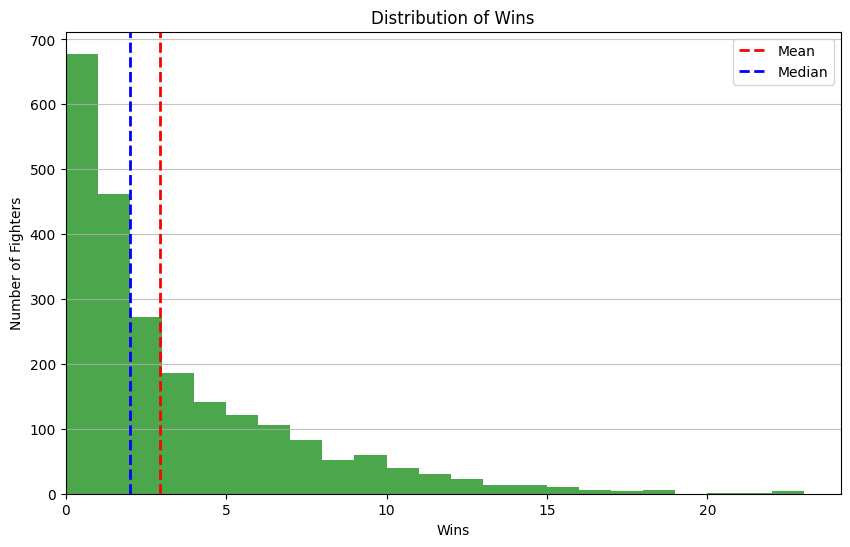

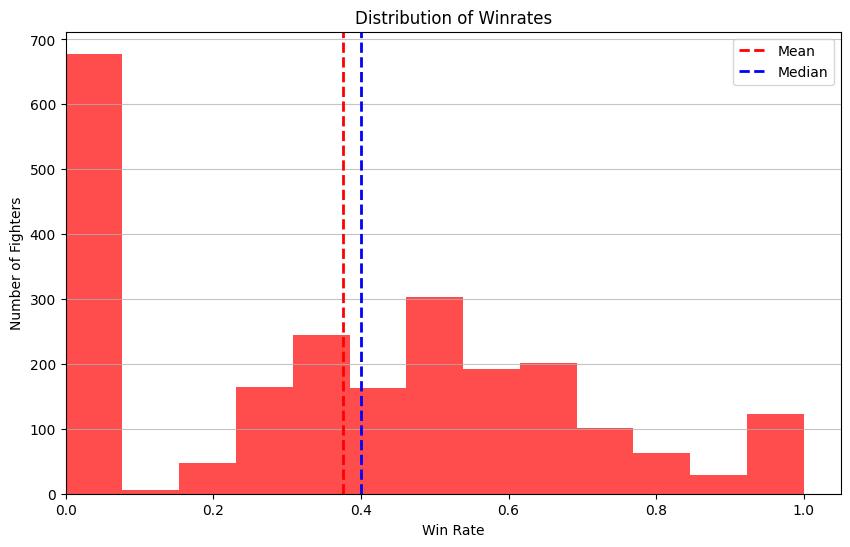

In [18]:
mean_wins = fighters_df["Wins"].mean()
median_wins = fighters_df["Wins"].median()

plt.figure(figsize=(10, 6))
plt.hist(fighters_df["Wins"], bins=int(fighters_df["Wins"].max()), color='green', alpha=0.7)
plt.title('Distribution of Wins')
plt.xlabel('Wins')
plt.ylabel('Number of Fighters')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0)
plt.axvline(mean_wins, color='red', linestyle='dashed',
            linewidth=2, label='Mean')
plt.axvline(median_wins, color='blue', linestyle='dashed',
            linewidth=2, label='Median')
plt.legend()

plt.show()

mean_wr = fighters_df["Winrate"].mean()
median_wr = fighters_df["Winrate"].median()
plt.figure(figsize=(10, 6))
plt.hist(fighters_df["Winrate"], bins='auto', color='red', alpha=0.7)
plt.title('Distribution of Winrates')
plt.xlabel('Win Rate')
plt.ylabel('Number of Fighters')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0)
plt.axvline(mean_wr, color='red', linestyle='dashed',
            linewidth=2, label='Mean')
plt.axvline(median_wr, color='blue', linestyle='dashed',
            linewidth=2, label='Median')
plt.legend()
plt.show()

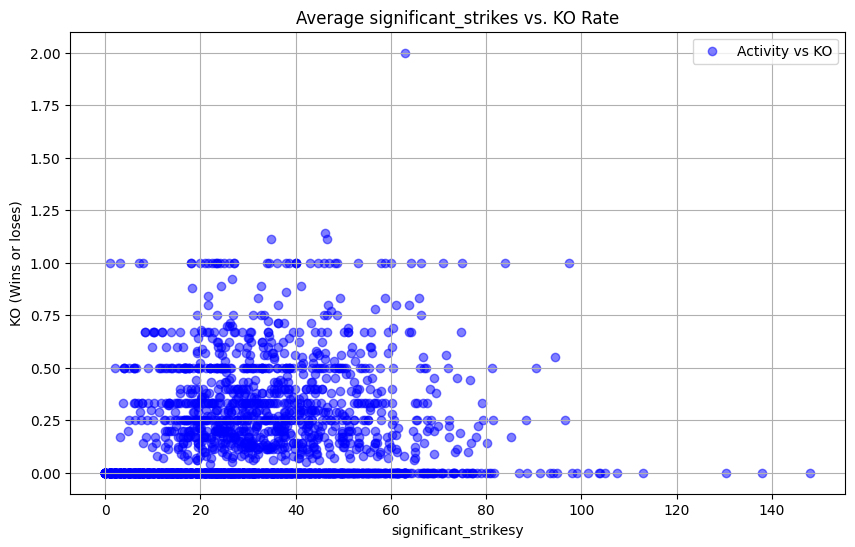

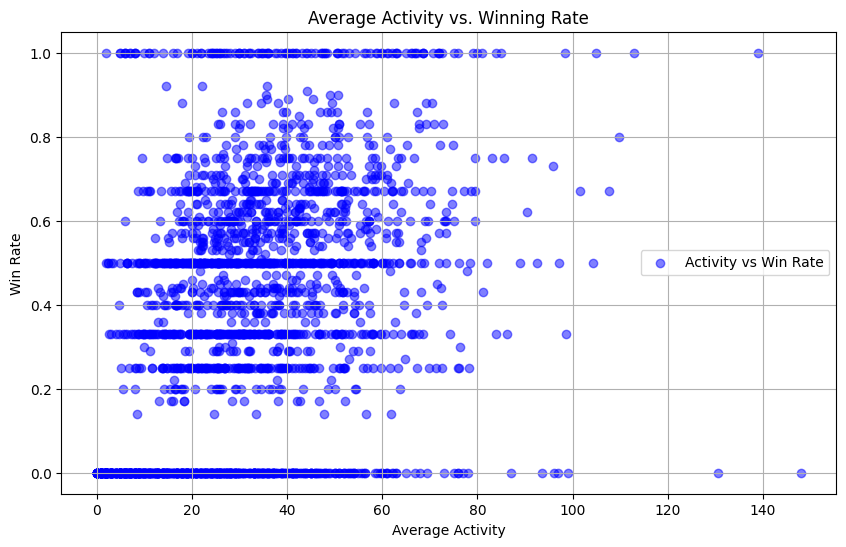

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(fighters_df["Average_significant_strikes"], fighters_df["Average_knockdowns"], color='blue', alpha=0.5, label='Activity vs KO')
plt.title('Average significant_strikes vs. KO Rate')
plt.xlabel('significant_strikesy')
plt.ylabel('KO (Wins or loses)')
plt.legend()
plt.grid(True)
plt.show()

# Improved Scatter plot for Average Activity vs. Win Rate
plt.figure(figsize=(10, 6))
plt.scatter(fighters_df["Average_activity"], fighters_df["Winrate"], color='blue', alpha=0.5, label='Activity vs Win Rate')
plt.title('Average Activity vs. Winning Rate')
plt.xlabel('Average Activity')
plt.ylabel('Win Rate')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# cor_df = fighters_df.drop(["Fighter_name"], axis=1)
# correlation_matrix = cor_df.corr()


# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
# plt.title('Correlation Matrix of Fighter Statistics')
# plt.show()

# OLS

Now, we are going to construct OLS method for predicting the duration of fight in seconds. However, our dataframe contains male and female fighters and it is not relevant to predict duration fight in combined dataframe, because man and woman can not have much up in UFC, so we are going to divide dataframe in two: for males and for females

In [21]:
df_fil["Gender"] = np.where(df_fil["Weight_Class"].str.contains("Women"), 1, 0)
df_man = df_fil.loc[df_fil["Gender"] == 0].drop(["Gender"], axis=1).reset_index(drop=True)
df_woman = df_fil.loc[df_fil["Gender"] != 0].drop(["Gender"], axis=1).reset_index(drop=True)

Variables in "Weight_Class" is ordinal, so to make our future OLS more relevent, we need to divide this column to many distinct columns. Each this column will represent the distinct weight category, so if fighters belong to this category we will put 1, if not 0 (It is clear that fighters in one fight can only belongs to one category).

In [22]:
df_man_clear = weight_breaker(df_man)
df_woman_clear = weight_breaker(df_woman)

df_man_clear

,Fighter 1,Fighter 2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Winner,Seconds,Lightweight,Bantamweight,Welterweight,Middleweight,Light Heavyweight,Featherweight,Heavyweight,Flyweight
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,Arman Tsarukyan,64.0,1,0,0,0,0,0,0,0
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,Jalin Turner,169.0,1,0,0,0,0,0,0,0
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,Deiveson Figueiredo,900.0,0,1,0,0,0,0,0,0
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,Sean Brady,703.0,0,0,1,0,0,0,0,0
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,Joaquim Silva,900.0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,Dan Henderson,480.0,0,0,0,1,0,0,0,0
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,David Abbott,43.0,0,0,0,0,0,0,1,0
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,Mike van Arsdale,661.0,0,0,0,0,0,0,1,0
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,Carlos Newton,52.0,0,0,0,1,0,0,0,0


In [23]:
winrates_df = history_winrate(df_man_clear)

In [24]:


names = [ele.replace(" ", "_") for ele in winrates_df.columns.to_list()]
winrates_df.columns = names

winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Lightweight,Bantamweight,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0.88,0.77
1,Jalin Turner,Bobby Green,1.0,0.0,33.0,15.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0.56,0.59
2,Deiveson Figueiredo,Rob Font,0.0,0.0,45.0,46.0,4.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0.75,0.75
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,0,0,1,0,0,0,0,0,0.83,0.75
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,1,0,0,0,0,0,0,0,0.56,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,0,0,1,0,0,0,0,1.00,1.00
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0.00,0.00
6133,Mike van Arsdale,Joe Pardo,0.0,0.0,27.0,4.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0.00,0.00
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,0,0,0,1,0,0,0,0,0.00,0.00


In [25]:
categories_all = [ele for ele in winrates_df.columns if "Fighter" in ele or "winrate" in ele]
categories = [(categories_all[i], categories_all[i+1]) for i in range(0, len(categories_all), 2)]

swapper(winrates_df, categories)



We have lots of zeroes in this dataframe so let us try to remove them or make more meaningful

In [26]:
winrates_df['Winrate_1_is_0'] = np.where(winrates_df["Current_winrate_F1"] == 0, 1, 0)
winrates_df['Winrate_2_is_0'] = np.where(winrates_df["Current_winrate_F2"] == 0, 1, 0)

In [27]:
winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.88,0.77,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Rob Font,Deiveson Figueiredo,0.0,0.0,46.0,45.0,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,1,0,0,0,0,0,0.83,0.75,0,0
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,0,0,0,0,0,0,0.56,0.53,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Joe Pardo,Mike van Arsdale,0.0,0.0,4.0,27.0,0.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,0,1,0,0,0,0,0.00,0.00,1,1


# OLS

In [28]:
winrates_df["Seconds"].value_counts()

Seconds
900.0    2686
600.0      39
300.0      20
299.0      20
255.0      15
         ... 
319.0       1
390.0       1
701.0       1
670.0       1
601.0       1
Name: count, Length: 820, dtype: int64

In [29]:
winrates_df_model = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1).copy()

model_Time=smf.ols(f"Seconds ~ {' + '.join(winrates_df_model)}", data=winrates_df)
print(model_Time.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                Seconds   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     580.8
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:39:34   Log-Likelihood:                -41059.
No. Observations:                6136   AIC:                         8.216e+04
Df Residuals:                    6116   BIC:                         8.229e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            174.9132     15

Now It is seem that weight class in unsignificant variable, so let test their joint significance

In [30]:
weights = winrates_df[['Bantamweight', 'Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight']]

test_model = smf.ols(formula=f"Seconds ~ {' + '.join(weights.columns)}", data=winrates_df).fit()

f_statistic = test_model.fvalue
p_value = test_model.f_pvalue


if p_value < 0.05:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Reject the null hypothesis.


It seems their are significant. Now let perform model selection with AIC to create the best model

In [31]:
# LASSO SELECTION IS DONE
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(winrates_df_model, winrates_df["Seconds"])
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


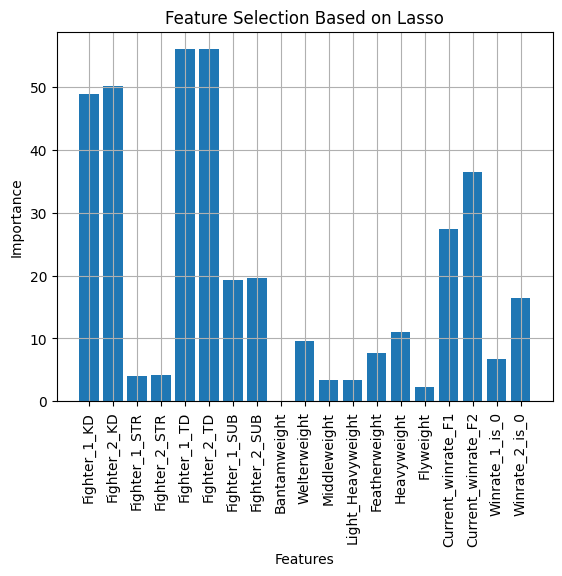

In [32]:

# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(winrates_df_model, winrates_df["Seconds"])

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

names = winrates_df_model.columns
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [33]:

selected_model = winrates_df_model[np.array(names)[lasso1_coef>3]]

selected_model

,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.88,0.77,0,0
1,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.59,0.56,0,0
2,0.0,0.0,46.0,45.0,0.0,4.0,0.0,0.0,0,0,0,0,0,0.75,0.75,0,0
3,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,1,0,0,0,0,0.83,0.75,0,0
4,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,0,0,0,0,0,0.56,0.53,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,0,1,0,0,0,1.00,1.00,0,0
6132,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,1,0.00,0.00,1,1
6133,0.0,0.0,4.0,27.0,0.0,1.0,1.0,1.0,0,0,0,0,1,0.00,0.00,1,1
6134,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0,1,0,0,0,0.00,0.00,1,1


In [34]:
model_Time_selected=smf.ols(f"Seconds ~ {' + '.join(selected_model)}", data=winrates_df).fit().summary()

model_Time_selected

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     649.3
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:39:36   Log-Likelihood:                -41059.
No. Observations:                6136   AIC:                         8.215e+04
Df Residuals:                    6118   BIC:                         8.228e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            175.1434     14.734     11.887      0.000     146.259     204.028
Fighter_1_KD         -48.9773      5.202     -9.415      0.000     -59.175     -38.779
Fighter_2_KD         -50.2480      5.195     -9.672      0.000     -60.432     -40.064
Fighter_1_STR          3.9810      0.119     33.559      0.000       3.748       4.214
Fighter_2_STR          4.1865      0.121     34.457      0.000       3.948       4.425
Fighter_1_TD          56.0593      1.585     35.379      0.000      52.953      59.166
Fighter_2_TD          56.0310      1.619     34.619      0.000      52.858      59.204
Fighter_1_SUB         19.2641      3.035      6.347      0.000      13.314      25.214
Fighter_2_SUB         19.5879      3.066      6.388      0.000      13.577      25.599
Welterweight           9.2767      7.112      1.304      0.192      -4.665      23.219
Middleweight           3.1235      7.699      0.406      0.685     -11.970      18.217
Light_Heavyweight     -3.4110     11.157     -0.306      0.760     -25.282      18.460
Featherweight         -7.9740      8.650     -0.922      0.357     -24.931       8.983
Heavyweight          -11.2819      9.061     -1.245      0.213     -29.045       6.481
Current_winrate_F1    27.3407     14.296      1.913      0.056      -0.684      55.366
Current_winrate_F2    36.5315     14.334      2.549      0.011       8.432      64.632
Winrate_1_is_0         6.7571     11.273      0.599      0.549     -15.343      28.857
Winrate_2_is_0        16.5051     11.347      1.455      0.146      -5.740      38.750
==============================================================================
Omnibus:                       43.594   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.676
Skew:                           0.195   Prob(JB):                     3.28e-10
Kurtosis:                       2.863   Cond. No.                         501.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let us calculate accuracy score for OLS model. To do it, we will need to convert preditions of variable "Second" into ordinal variable "Round" (the same we will need to perform with true values, because column "Round" was dropped at the beginning of research), however accuracy score is bad in distinguish between different classes so we will use f1 score for this purposes

In [35]:
predictor_data = winrates_df_model

predictions = model_Time.fit().predict(predictor_data)

print(predictions)

0       218.310246
1       359.076729
2       818.315205
3       703.696602
4       835.380014
           ...    
6131    636.608737
6132    286.946895
6133    410.947461
6134    319.375632
6135    450.989958
Length: 6136, dtype: float64


In [36]:
accuracy_win = winrates_df.copy()

accuracy_win["Second_Pred"] = predictions
accuracy_win["Round_Pred"] = accuracy_win["Second_Pred"].apply(second_to_round)
accuracy_win["Round"] = accuracy_win["Seconds"].apply(second_to_round)

conf_mat = metrics.confusion_matrix(accuracy_win["Round"], accuracy_win["Round_Pred"])
f_1_score = metrics.f1_score(accuracy_win["Round"], accuracy_win["Round_Pred"], average="macro")

pred_accuracy = (accuracy_win["Round_Pred"] == accuracy_win["Round"]).value_counts()

print(f"Accuracy: {round(pred_accuracy[0]/(pred_accuracy[0]+pred_accuracy[1]),2)}")

Accuracy: 0.58


In [37]:
winrates_df["Winner"] = pd.to_numeric(winrates_df["Winner"])

In [38]:
winrates_df

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.88,0.77,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Rob Font,Deiveson Figueiredo,0.0,0.0,46.0,45.0,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Sean Brady,Kelvin Gastelum,0.0,0.0,14.0,18.0,5.0,0.0,3.0,0.0,...,1,0,0,0,0,0,0.83,0.75,0,0
4,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,...,0,0,0,0,0,0,0.56,0.53,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,0.0,2.0,28.0,20.0,3.0,2.0,0.0,1.0,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Joe Pardo,Mike van Arsdale,0.0,0.0,4.0,27.0,0.0,1.0,1.0,1.0,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Carlos Newton,Bob Gilstrap,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,...,0,1,0,0,0,0,0.00,0.00,1,1


# Logit

In [39]:
winrates_df_model_logit = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1).copy()

model_logit=smf.logit(f"Winner ~ {' + '.join(winrates_df_model_logit)}", data=winrates_df)
print(model_logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.332815
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 6136
Model:                          Logit   Df Residuals:                     6116
Method:                           MLE   Df Model:                           19
Date:                Thu, 18 Apr 2024   Pseudo R-squ.:                  0.5198
Time:                        21:39:36   Log-Likelihood:                -2042.2
converged:                       True   LL-Null:                       -4253.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1092      0.237      0.462      0.644      -0.354       0.573
Fight

Let's calculate the accuracy score for logit model

In [40]:
predictor_data_logit = winrates_df_model_logit

predictions_logit = model_logit.fit().predict(predictor_data_logit)

Optimization terminated successfully.
         Current function value: 0.332815
         Iterations 7


Calculate the accuracy score for logit model

In [41]:
predictions_logit = np.where(predictions_logit > 0.5, 1, 0)

tp_and_fp = (winrates_df["Winner"] == predictions_logit).value_counts()

print(f"The accuracy score fot logit model: {(tp_and_fp[0]/(tp_and_fp[0]+tp_and_fp[1]))}")

The accuracy score fot logit model: 0.872555410691004


In [42]:
metrics.f1_score(winrates_df['Winner'], predictions_logit)

0.8732166018158236

In [43]:
history_avg = winrates_df.copy()

replace_stats_with_avg(history_avg)

history_avg

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,0.12,0.32,46.62,35.09,3.38,1.18,0.00,0.55,...,0,0,0,0,0,0,0.88,0.77,0,0
1,Bobby Green,Jalin Turner,0.18,0.33,74.73,38.89,0.91,0.33,0.23,0.67,...,0,0,0,0,0,0,0.59,0.56,0,0
2,Rob Font,Deiveson Figueiredo,0.58,0.67,46.25,24.42,0.67,1.00,0.42,1.67,...,0,0,0,0,0,0,0.75,0.75,0,0
3,Sean Brady,Kelvin Gastelum,0.17,0.31,52.17,44.88,2.33,0.94,0.67,0.12,...,1,0,0,0,0,0,0.83,0.75,0,0
4,Joaquim Silva,Clay Guida,0.22,0.18,35.44,31.26,0.11,2.24,0.33,0.47,...,0,0,0,0,0,0,0.56,0.53,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Dan Henderson,Carlos Newton,1.00,0.00,31.00,1.00,1.00,1.00,1.00,3.00,...,0,1,0,0,0,0,1.00,1.00,0,0
6132,David Abbott,Hugo Duarte,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0.00,0.00,1,1
6133,Joe Pardo,Mike van Arsdale,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0.00,0.00,1,1
6134,Carlos Newton,Bob Gilstrap,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,1,0,0,0,0,0.00,0.00,1,1


Run new logit model for history_avg dataframe

In [44]:
model_logit2=smf.logit(f"Winner ~ {' + '.join(history_avg.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=history_avg)
print(model_logit2.fit().summary())

Optimization terminated successfully.
         Current function value: 0.674382
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 6136
Model:                          Logit   Df Residuals:                     6116
Method:                           MLE   Df Model:                           19
Date:                Thu, 18 Apr 2024   Pseudo R-squ.:                 0.02705
Time:                        21:39:48   Log-Likelihood:                -4138.0
converged:                       True   LL-Null:                       -4253.0
Covariance Type:            nonrobust   LLR p-value:                 3.266e-38
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0454      0.163     -0.279      0.780      -0.365       0.274
Fight

In [45]:
model_Time2=smf.ols(f"Seconds ~ {' + '.join(history_avg.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds', 'Lightweight'], axis=1))}", data=history_avg)
print(model_Time2.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                Seconds   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     14.14
Date:                Thu, 18 Apr 2024   Prob (F-statistic):           6.48e-45
Time:                        21:39:48   Log-Likelihood:                -44091.
No. Observations:                6136   AIC:                         8.822e+04
Df Residuals:                    6116   BIC:                         8.836e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            574.2388     25

# Some additional functions to work with dataframe

In [46]:
get_stats_of_fighter(fighters_df, "Arman Tsarukyan")
get_fights_of_fighter(winrates_df, "Arman Tsarukyan")

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,...,Welterweight,Middleweight,Light_Heavyweight,Featherweight,Heavyweight,Flyweight,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.88,0.77,0,0
193,Joaquim Silva,Arman Tsarukyan,0.0,0.0,23.0,80.0,0.0,4.0,0.0,0.0,...,0,0,0,0,0,0,0.62,0.86,0,0
376,Damir Ismagulov,Arman Tsarukyan,0.0,0.0,36.0,34.0,0.0,7.0,0.0,0.0,...,0,0,0,0,0,0,1.00,0.83,0,0
705,Arman Tsarukyan,Joel Alvarez,0.0,0.0,36.0,7.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.80,0.80,0,0
869,Christos Giagos,Arman Tsarukyan,0.0,1.0,1.0,22.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.50,0.75,0,0
1119,Matt Frevola,Arman Tsarukyan,0.0,0.0,16.0,50.0,0.0,10.0,0.0,0.0,...,0,0,0,0,0,0,0.75,0.67,0,0
1325,Davi Ramos,Arman Tsarukyan,0.0,0.0,33.0,91.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0.67,0.50,0,0
1648,Olivier Aubin-Mercier,Arman Tsarukyan,0.0,0.0,23.0,47.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0.64,0.00,0,1
1755,Islam Makhachev,Arman Tsarukyan,0.0,0.0,14.0,13.0,4.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0.83,0.00,0,1


# CHECKING THE ASSUMPTIONS OF BLUE

## To test
 - Linearity
 - Random sampling
 - No perfect collinearity
 - Zero conditional mean
 - Homoskedasticity

## 1. Linearity

In [47]:
winrates_df.columns

Index(['Fighter_1', 'Fighter_2', 'Fighter_1_KD', 'Fighter_2_KD',
       'Fighter_1_STR', 'Fighter_2_STR', 'Fighter_1_TD', 'Fighter_2_TD',
       'Fighter_1_SUB', 'Fighter_2_SUB', 'Method', 'Winner', 'Seconds',
       'Lightweight', 'Bantamweight', 'Welterweight', 'Middleweight',
       'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight',
       'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0'],
      dtype='object')

In [48]:
winrates_df_for_plot = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Lightweight'], axis=1).copy()

winrates_df_for_plot["Round"] = winrates_df_for_plot["Seconds"].apply(lambda x: math.ceil(x/360))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


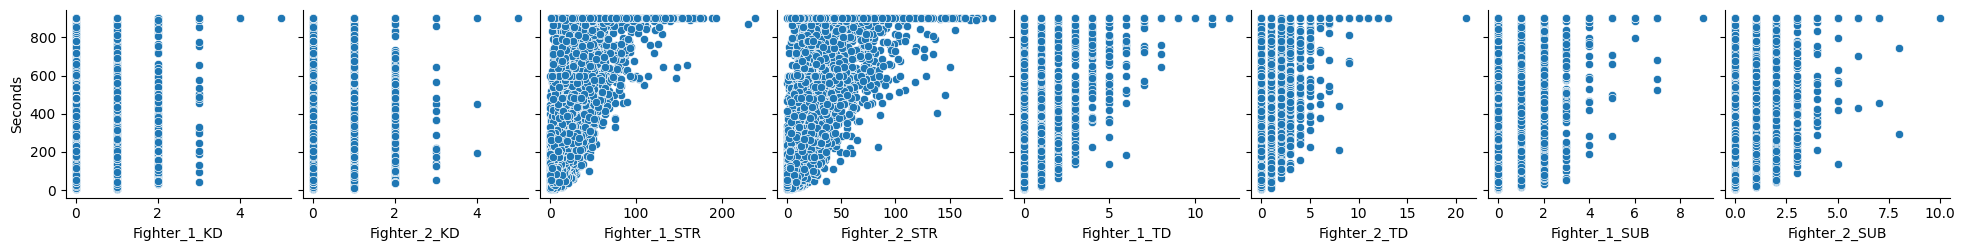

In [49]:
sns.pairplot(winrates_df_for_plot,   x_vars=['Fighter_1_KD', 'Fighter_2_KD','Fighter_1_STR',   'Fighter_2_STR', 'Fighter_1_TD', 'Fighter_2_TD','Fighter_1_SUB', 'Fighter_2_SUB'], y_vars="Seconds")

### !!! REMOVE OUTLIERS

## MEAN OF RESIDUALS

In [50]:
predidted_time = model_Time.fit().predict(winrates_df_model)

residuals = winrates_df["Seconds"] - predidted_time

mean_of_residuals = residuals.sum()/residuals.size

mean_of_residuals

-1.1834103159965872e-12

OK!

## CHECK FOR HOMOSKEDASTICITY

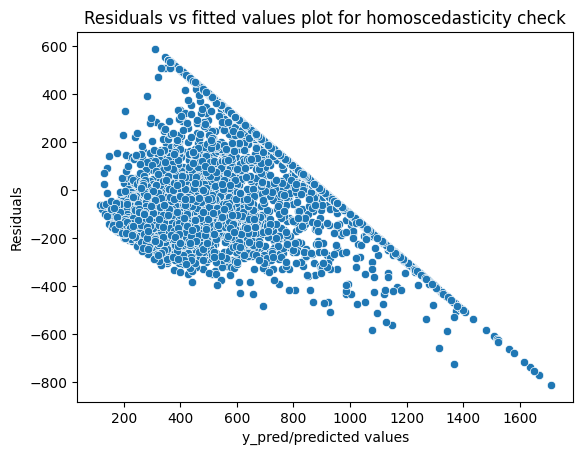

In [51]:

p = sns.scatterplot(x=predidted_time, y=residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

Null Hypothesis: Error terms are homoscedastic

Alternative Hypothesis: Error terms are heteroscedastic.

In [52]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, winrates_df_model)
lzip(name, test)

[('F statistic', 0.9160839858736253), ('p-value', 0.9922238551676523)]

We can not reject null hypotheses

In [53]:
bartlett(predictions, residuals)

BartlettResult(statistic=526.464690580251, pvalue=1.6598902504100145e-116)

In [54]:
het_white(residuals, model_Time.exog)


(1130.6522231233541,
 1.2177952379737092e-138,
 7.60364820641916,
 3.4323117422152473e-157)

## NORMALITY

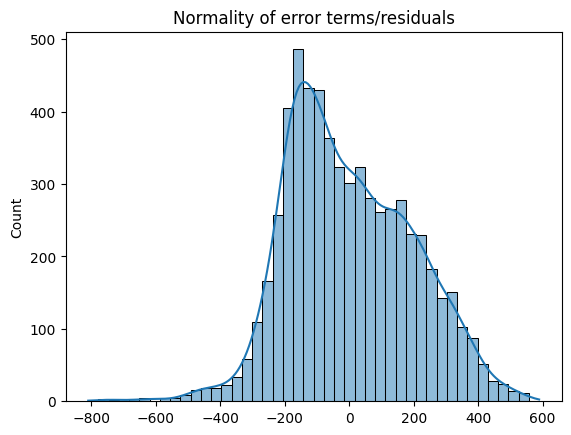

In [55]:
p = sns.histplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

Normal OK

In [56]:
normaltest(residuals)

NormaltestResult(statistic=43.577649204330726, pvalue=3.4453528663716933e-10)

Not normal 

## AUTOCORRELATION

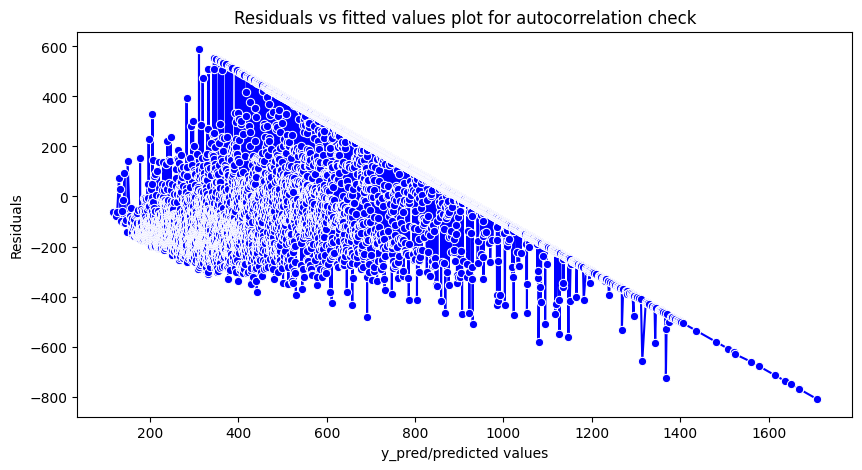

In [57]:
plt.figure(figsize=(10,5))
p = sns.lineplot(y=residuals,x=predidted_time,marker='o',color='blue')
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
p = plt.title('Residuals vs fitted values plot for autocorrelation check')

In [58]:
diag.acorr_ljungbox(residuals, lags=12)

,lb_stat,lb_pvalue
1,8.145587,4.316607e-03
2,24.307755,5.267906e-06
3,24.699175,1.784619e-05
4,40.076309,4.173955e-08
5,45.294932,1.263742e-08
6,48.876313,7.893243e-09
7,48.989444,2.279785e-08
8,52.722051,1.220611e-08
9,60.477135,1.084769e-09
10,66.786942,1.842374e-10


Not autocorrelated

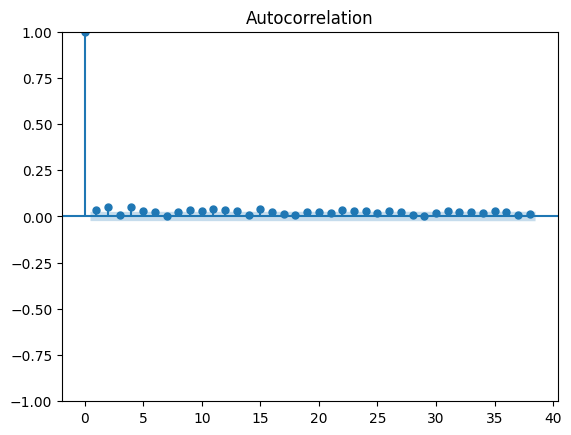

In [59]:
sm.graphics.tsa.plot_acf(residuals)
plt.show()

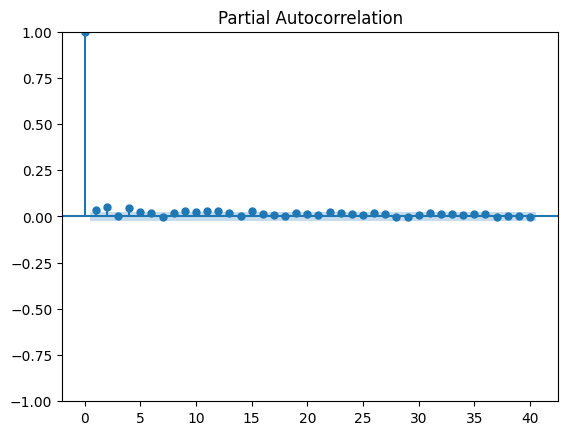

In [60]:
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

## NO PERFECT COLLINEARITY

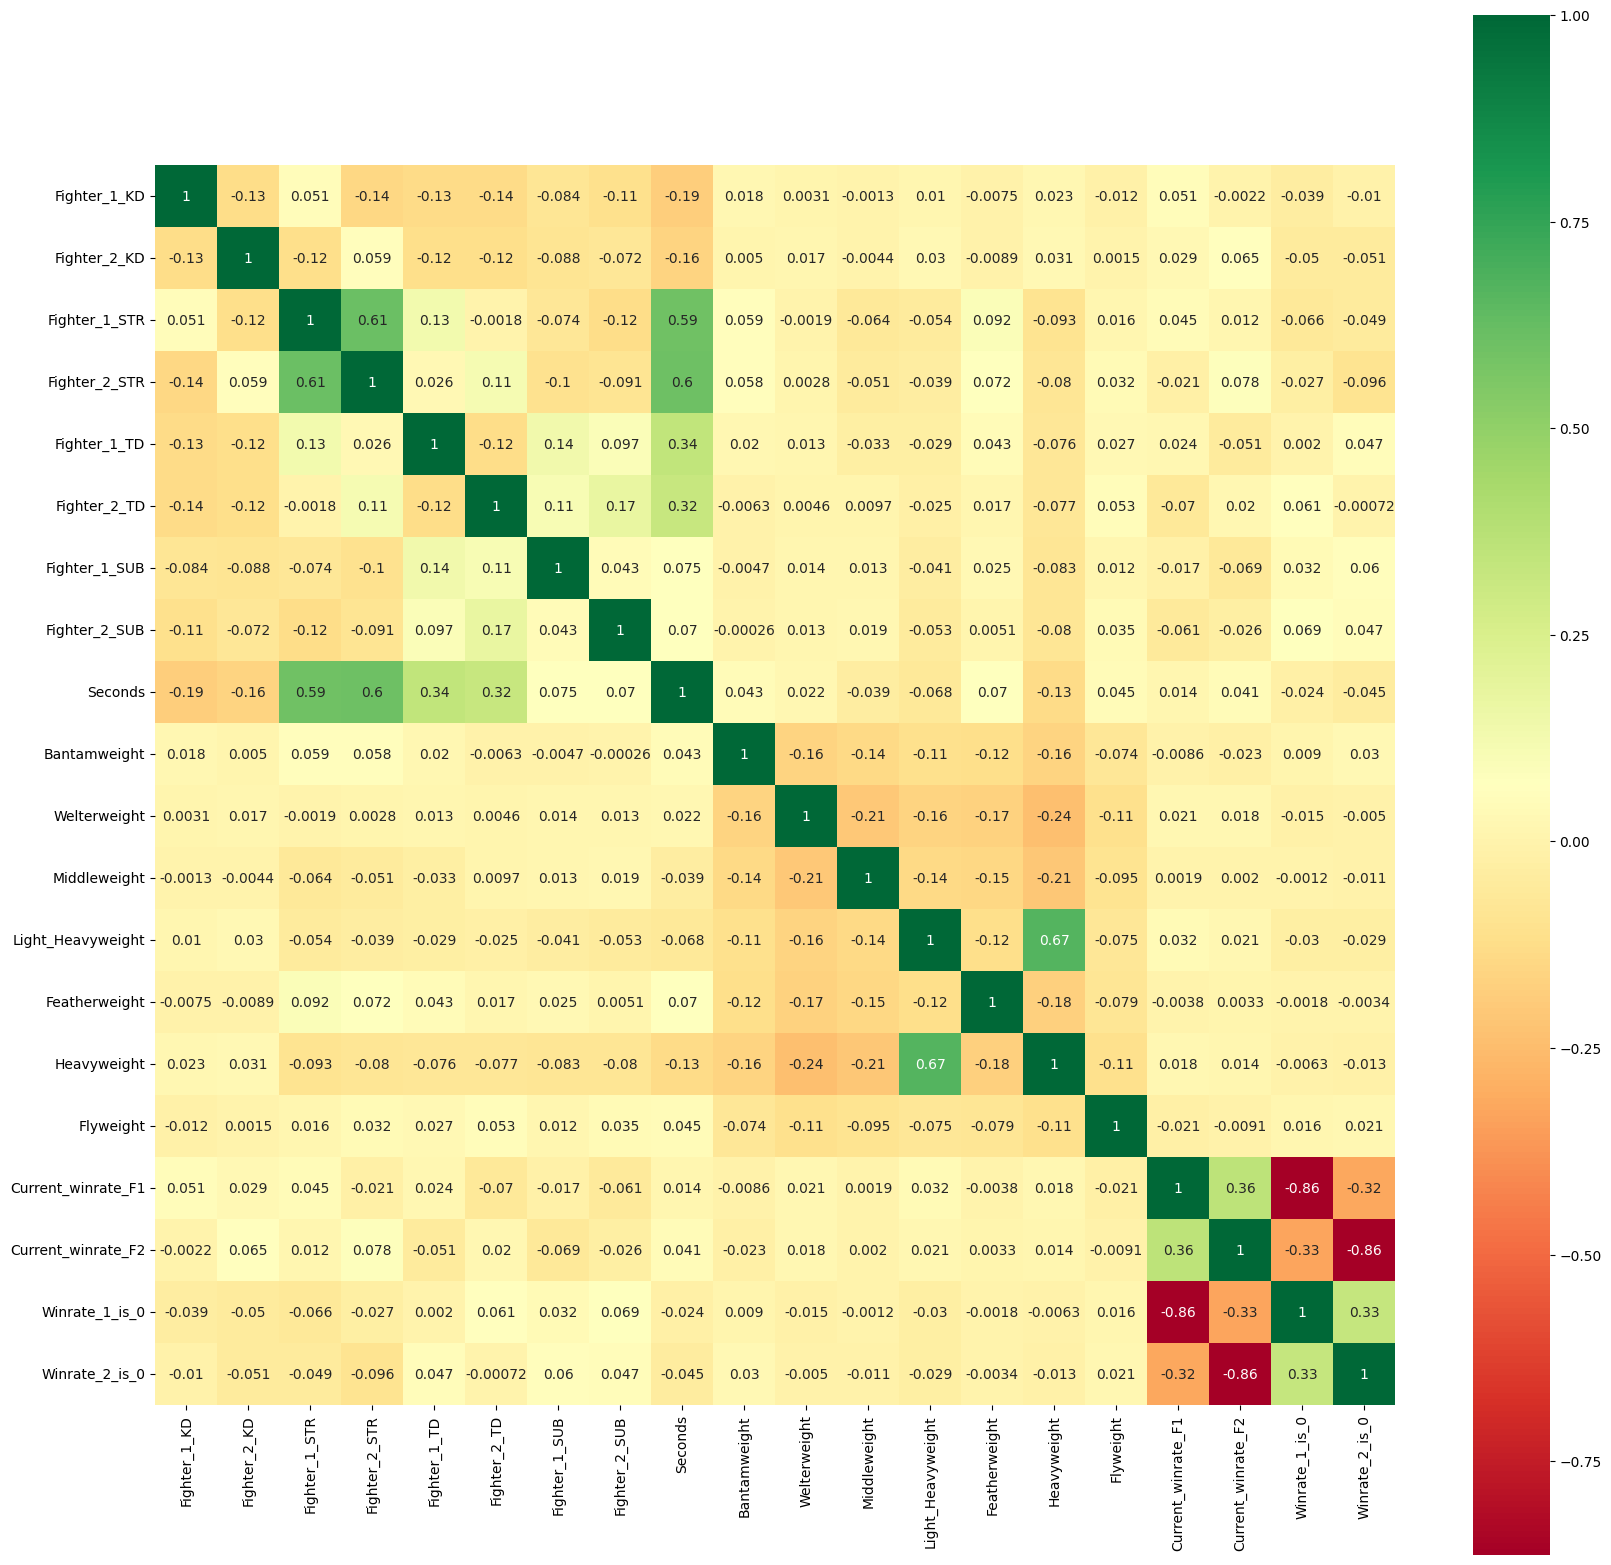

In [61]:
winrates_df_model = winrates_df.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Lightweight'], axis=1).copy()

plt.figure(figsize=(20,20)) 
p=sns.heatmap(winrates_df_model.corr(), annot=True,cmap='RdYlGn',square=True)  

OK

## OUTLIERS CLEAN

In [62]:
winrates_df_model.columns

Index(['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB',
       'Seconds', 'Bantamweight', 'Welterweight', 'Middleweight',
       'Light_Heavyweight', 'Featherweight', 'Heavyweight', 'Flyweight',
       'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0'],
      dtype='object')

<Axes: >

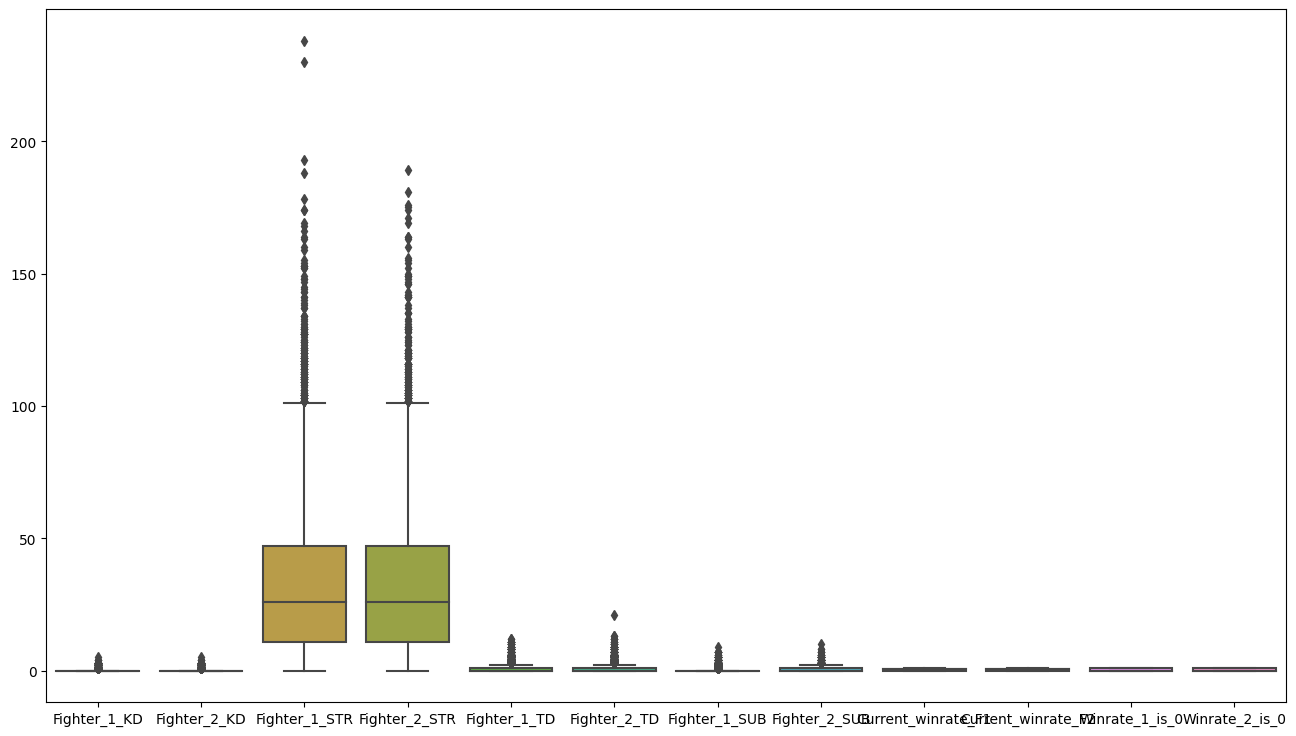

In [63]:
plt.figure(figsize=(16,9))
sns.boxplot(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])

<Axes: >

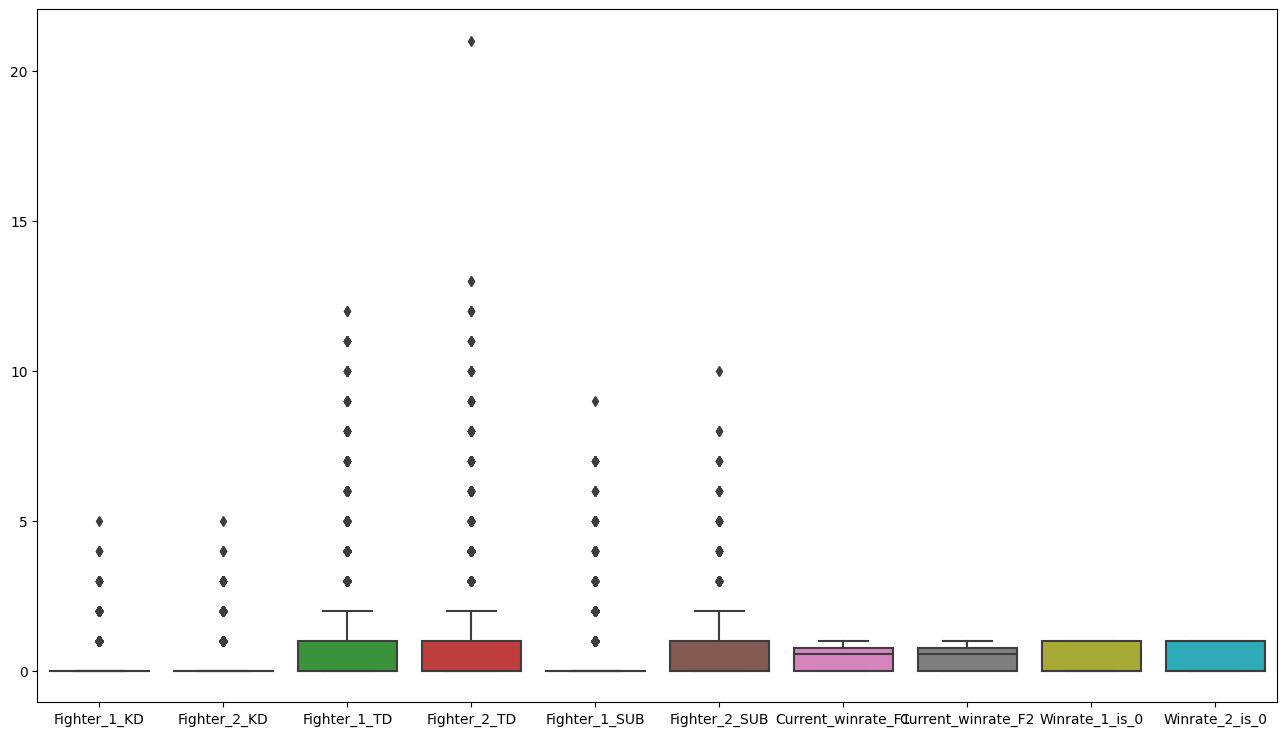

In [64]:
plt.figure(figsize=(16,9))
sns.boxplot(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])

<Axes: >

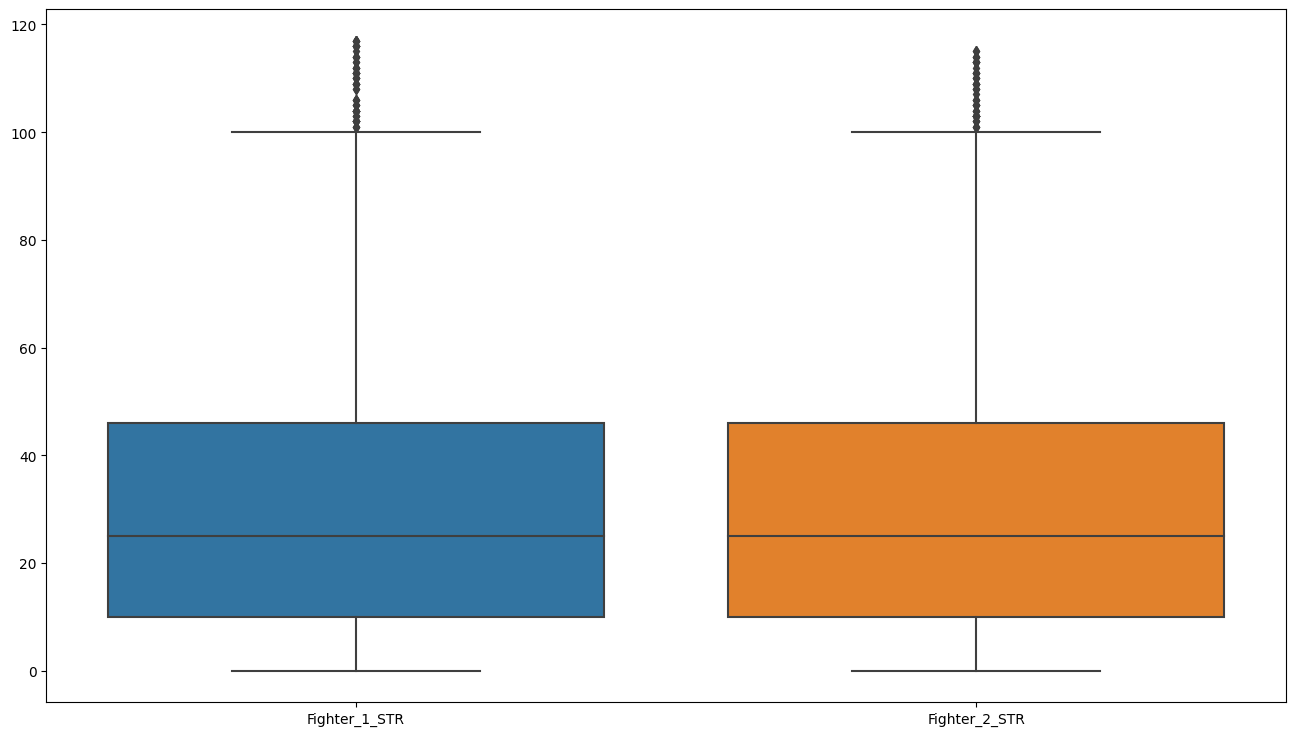

In [65]:
a = winrates_df_model[(np.abs(stats.zscore(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])) < 3).all(axis=1)]

plt.figure(figsize=(16,9))
sns.boxplot(a[['Fighter_1_STR', 'Fighter_2_STR']])

In [66]:
outliners_off = a.reset_index(drop=True)

In [67]:
new_m = smf.ols(f"Seconds ~ {' + '.join(outliners_off.drop(['Seconds'], axis=1))}", data=outliners_off).fit()
new_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     606.6
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:39:51   Log-Likelihood:                -33367.
No. Observations:                5034   AIC:                         6.677e+04
Df Residuals:                    5014   BIC:                         6.691e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            145.3451     15.966      9.103      0.000     114.044     176.646
Fighter_1_KD         -77.7502      7.048    -11.032      0.000     -91.566     -63.934
Fighter_2_KD         -71.9922      7.058    -10.200      0.000     -85.829     -58.156
Fighter_1_STR          4.8709      0.136     35.880      0.000       4.605       5.137
Fighter_2_STR          4.8352      0.137     35.212      0.000       4.566       5.104
Fighter_1_TD          64.6200      2.013     32.107      0.000      60.674      68.566
Fighter_2_TD          66.0428      2.251     29.333      0.000      61.629      70.457
Fighter_1_SUB          4.6570      4.767      0.977      0.329      -4.689      14.003
Fighter_2_SUB          4.1483      4.624      0.897      0.370      -4.917      13.214
Bantamweight          -0.9675     10.225     -0.095      0.925     -21.012      19.077
Welterweight           9.5474      8.330      1.146      0.252      -6.783      25.878
Middleweight           4.8150      8.799      0.547      0.584     -12.434      22.064
Light_Heavyweight     -3.2301     11.295     -0.286      0.775     -25.374      18.914
Featherweight        -24.5310      9.787     -2.507      0.012     -43.717      -5.345
Heavyweight           -6.5815      9.858     -0.668      0.504     -25.908      12.745
Flyweight             -1.6469     13.385     -0.123      0.902     -27.888      24.594
Current_winrate_F1    23.1496     14.785      1.566      0.117      -5.836      52.135
Current_winrate_F2    29.5297     14.956      1.974      0.048       0.209      58.851
Winrate_1_is_0         7.4169     11.691      0.634      0.526     -15.502      30.336
Winrate_2_is_0        11.3603     11.794      0.963      0.335     -11.761      34.482
==============================================================================
Omnibus:                       99.779   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.294
Skew:                           0.350   Prob(JB):                     1.37e-23
Kurtosis:                       3.110   Cond. No.                         474.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

a - norm df

1) Dummy STR remain
2)  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


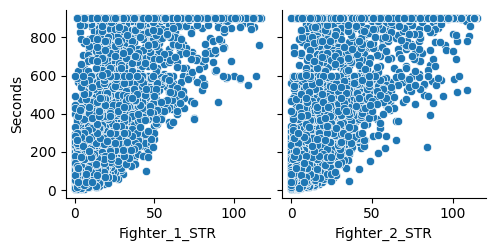

In [68]:
sns.pairplot(outliners_off,   x_vars=['Fighter_1_STR',   'Fighter_2_STR'], y_vars="Seconds")

Remove heteroskedasticity

1) Methode one:

In [69]:
for_fight_str = np.where(a['Fighter_1_STR'] <= 65, 0, 1)
for_second_str = np.where(a['Fighter_2_STR'] <= 65, 0, 1)

df_for_hetero = pd.DataFrame({"Fighter_1_Tough": for_fight_str, "Fighter_2_Tough": for_second_str})

hetero_check_1 = pd.concat([outliners_off, df_for_hetero], axis=1)

In [70]:
hetero_1 = smf.ols(f"Seconds ~ {' + '.join(hetero_check_1.drop(['Seconds'], axis=1))}", data=hetero_check_1).fit()
hetero_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     658.9
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:39:52   Log-Likelihood:                -33037.
No. Observations:                5034   AIC:                         6.612e+04
Df Residuals:                    5012   BIC:                         6.626e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             90.2706     15.100      5.978      0.000      60.669     119.872
Fighter_1_KD         -82.5758      6.622    -12.470      0.000     -95.558     -69.594
Fighter_2_KD         -78.8459      6.634    -11.884      0.000     -91.852     -65.839
Fighter_1_STR          6.5746      0.173     38.009      0.000       6.235       6.914
Fighter_2_STR          6.7003      0.175     38.384      0.000       6.358       7.043
Fighter_1_TD          56.1453      1.915     29.314      0.000      52.390      59.900
Fighter_2_TD          57.5250      2.134     26.951      0.000      53.341      61.709
Fighter_1_SUB          9.8431      4.471      2.202      0.028       1.079      18.608
Fighter_2_SUB          5.4972      4.332      1.269      0.205      -2.996      13.990
Bantamweight          -0.3751      9.578     -0.039      0.969     -19.152      18.402
Welterweight          11.2598      7.804      1.443      0.149      -4.040      26.560
Middleweight           4.4697      8.242      0.542      0.588     -11.688      20.627
Light_Heavyweight     -1.5527     10.581     -0.147      0.883     -22.295      19.190
Featherweight        -21.5056      9.168     -2.346      0.019     -39.479      -3.532
Heavyweight           -3.9604      9.237     -0.429      0.668     -22.069      14.148
Flyweight             -0.4246     12.542     -0.034      0.973     -25.012      24.163
Current_winrate_F1    16.7234     13.852      1.207      0.227     -10.433      43.880
Current_winrate_F2    38.0159     14.015      2.712      0.007      10.539      65.492
Winrate_1_is_0         9.4034     10.951      0.859      0.391     -12.066      30.873
Winrate_2_is_0        18.2026     11.051      1.647      0.100      -3.463      39.868
Fighter_1_Tough     -190.2686     11.525    -16.509      0.000    -212.863    -167.674
Fighter_2_Tough     -207.0198     11.336    -18.262      0.000    -229.243    -184.796
==============================================================================
Omnibus:                      122.845   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.179
Skew:                           0.363   Prob(JB):                     4.43e-30
Kurtosis:                       3.345   Cond. No.                         476.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

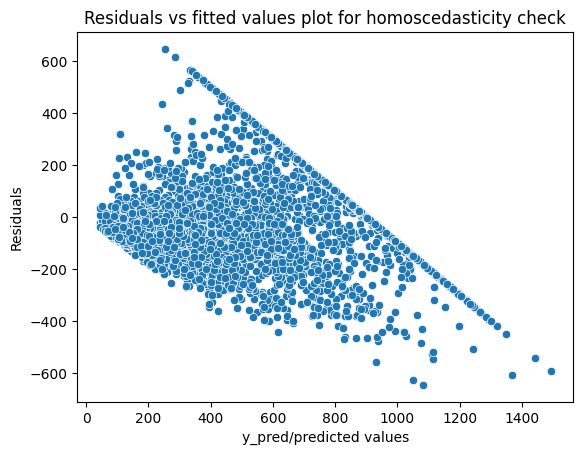

In [71]:
predidted_time = hetero_1.predict(hetero_check_1)

residuals = (hetero_check_1["Seconds"] - predidted_time).dropna()

p = sns.scatterplot(x=predidted_time, y=residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')

p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

In [78]:
hetero_21 = smf.ols(f"Seconds ~ {' + '.join(hetero_check_1.drop(['Bantamweight','Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight','Heavyweight', 'Flyweight', 'Seconds'], axis=1))}", data=hetero_check_2).fit()
hetero_21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Seconds   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     986.0
Date:                Thu, 18 Apr 2024   Prob (F-statistic):               0.00
Time:                        21:39:52   Log-Likelihood:                -33044.
No. Observations:                5034   AIC:                         6.612e+04
Df Residuals:                    5019   BIC:                         6.622e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             90.5578     14.335      6.317      0.000      62.454     118.661
Fighter_1_KD         -82.8105      6.622    -12.505      0.000     -95.793     -69.828
Fighter_2_KD         -79.0189      6.634    -11.911      0.000     -92.025     -66.013
Fighter_1_STR          6.5545      0.173     37.953      0.000       6.216       6.893
Fighter_2_STR          6.6960      0.174     38.416      0.000       6.354       7.038
Fighter_1_TD          56.0750      1.911     29.349      0.000      52.329      59.821
Fighter_2_TD          57.6648      2.129     27.089      0.000      53.492      61.838
Fighter_1_SUB          9.8013      4.459      2.198      0.028       1.059      18.544
Fighter_2_SUB          5.7079      4.326      1.319      0.187      -2.773      14.189
Current_winrate_F1    17.1931     13.854      1.241      0.215      -9.967      44.353
Current_winrate_F2    37.6195     14.014      2.684      0.007      10.146      65.093
Winrate_1_is_0         9.4532     10.954      0.863      0.388     -12.021      30.928
Winrate_2_is_0        17.7745     11.044      1.609      0.108      -3.877      39.426
Fighter_1_Tough     -190.5117     11.528    -16.526      0.000    -213.111    -167.912
Fighter_2_Tough     -207.3902     11.332    -18.302      0.000    -229.605    -185.175
==============================================================================
Omnibus:                      120.983   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.171
Skew:                           0.359   Prob(JB):                     1.21e-29
Kurtosis:                       3.347   Cond. No.                         467.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
predicted = hetero_21.predict(hetero_check_1)

residuals = hetero_check_1['Seconds'] - predicted

mean_er = residuals.sum()/residuals.shape[0]

mean_er

1.182306978228455e-12

## Logit model updated

In [80]:
def improve_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Improve the dataframe ability to construct good OLS models
    """
    outlieners_off = df[(np.abs(stats.zscore(winrates_df_model[['Fighter_1_KD', 'Fighter_2_KD', 'Fighter_1_STR', 'Fighter_2_STR',
       'Fighter_1_TD', 'Fighter_2_TD', 'Fighter_1_SUB', 'Fighter_2_SUB', 'Current_winrate_F1', 'Current_winrate_F2', 'Winrate_1_is_0',
       'Winrate_2_is_0']])) < 3).all(axis=1)].reset_index(drop=True)
    
    for_fight_str = np.where(outlieners_off['Fighter_1_STR'] <= 65, 0, 1)
    for_second_str = np.where(outlieners_off['Fighter_2_STR'] <= 65, 0, 1)

    df_for_tough = pd.DataFrame({"Fighter_1_Tough": for_fight_str, "Fighter_2_Tough": for_second_str})

    tough_df = pd.concat([outlieners_off, df_for_tough], axis=1)

    result = tough_df.drop(['Lightweight','Bantamweight','Welterweight', 'Middleweight', 'Light_Heavyweight', 'Featherweight','Heavyweight', 'Flyweight'], axis=1).reset_index(drop=True)

    return result
        

In [81]:
test = improve_df(winrates_df)
test

,Fighter_1,Fighter_2,Fighter_1_KD,Fighter_2_KD,Fighter_1_STR,Fighter_2_STR,Fighter_1_TD,Fighter_2_TD,Fighter_1_SUB,Fighter_2_SUB,Method,Winner,Seconds,Current_winrate_F1,Current_winrate_F2,Winrate_1_is_0,Winrate_2_is_0,Fighter_1_Tough,Fighter_2_Tough
0,Arman Tsarukyan,Beneil Dariush,1.0,0.0,8.0,2.0,0.0,0.0,0.0,0.0,KO/TKO Punch,1,64.0,0.88,0.77,0,0,0,0
1,Bobby Green,Jalin Turner,0.0,1.0,15.0,33.0,0.0,0.0,0.0,0.0,KO/TKO Punches,0,169.0,0.59,0.56,0,0,0,0
2,Rob Font,Deiveson Figueiredo,0.0,0.0,46.0,45.0,0.0,4.0,0.0,0.0,U-DEC,0,900.0,0.75,0.75,0,0,0,0
3,Joaquim Silva,Clay Guida,0.0,0.0,46.0,43.0,2.0,2.0,2.0,0.0,U-DEC,1,900.0,0.56,0.53,0,0,0,0
4,Punahele Soriano,Dustin Stoltzfus,0.0,1.0,31.0,64.0,0.0,4.0,0.0,1.0,SUB Rear Naked Choke,0,550.0,0.50,0.20,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029,Adriano Santos,Tulio Palhares,0.0,0.0,11.0,31.0,2.0,4.0,0.0,0.0,KO/TKO Punches,0,540.0,0.00,0.00,1,1,0,0
5030,Mark Coleman,Pete Williams,0.0,1.0,26.0,22.0,3.0,0.0,0.0,1.0,KO/TKO Kick,0,338.0,0.00,0.00,1,1,0,0
5031,David Abbott,Hugo Duarte,0.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,KO/TKO Punches,1,43.0,0.00,0.00,1,1,0,0
5032,Joe Pardo,Mike van Arsdale,0.0,0.0,4.0,27.0,0.0,1.0,1.0,1.0,SUB Keylock,0,661.0,0.00,0.00,1,1,0,0


In [83]:
winrates_df_model_logit = test.drop(['Fighter_1', 'Fighter_2', 'Winner', 'Method', 'Seconds'], axis=1).copy()

model_logit=smf.logit(f"Winner ~ {' + '.join(winrates_df_model_logit)}", data=test)
print(model_logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.324540
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 Winner   No. Observations:                 5034
Model:                          Logit   Df Residuals:                     5019
Method:                           MLE   Df Model:                           14
Date:                Thu, 18 Apr 2024   Pseudo R-squ.:                  0.5317
Time:                        21:40:36   Log-Likelihood:                -1633.7
converged:                       True   LL-Null:                       -3488.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2231      0.257      0.868      0.385      -0.281       0.727
Fight

Optimization terminated successfully.
         Current function value: 0.324540
         Iterations 7


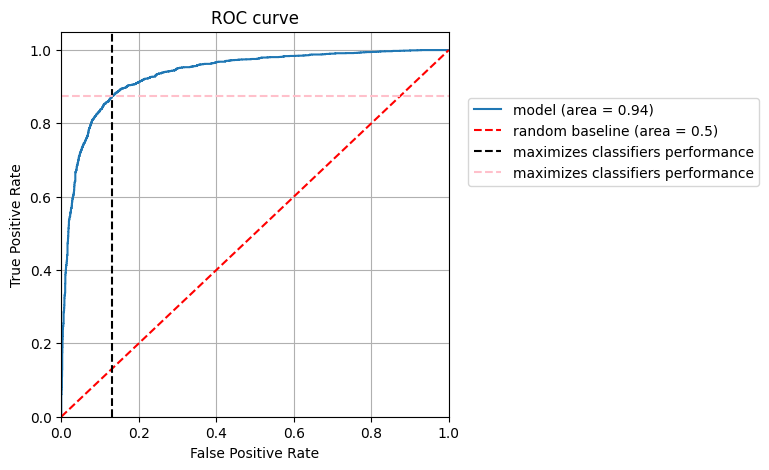

In [93]:
def plot_roc_curve(y_true, y_pred_prob):

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob)
    auc = round(metrics.roc_auc_score(y_true=y_true, y_score=y_pred_prob), 2)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f'model (area = {auc})')
    plt.plot([0, 1], [0, 1], 'r--', label='random baseline (area = 0.5)')

    id_x = pd.Series(abs(tpr - fpr), index=fpr).idxmax()
    plt.axvline(x=id_x, linestyle='dashed', color='black',
                label='maximizes classifiers performance')
    id_y = pd.Series(abs(tpr - fpr), index=tpr).idxmax()
    plt.axhline(y=id_y, linestyle='dashed', color='pink',
                label='maximizes classifiers performance')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc=(1.05, 0.6))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.show()

y_pred = model_logit.fit().predict(test)

plot_roc_curve(test['Winner'], y_pred)

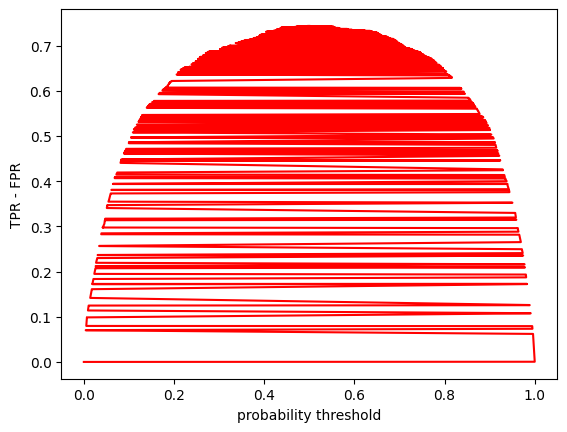

In [100]:
fpr, tpr, thresholds = metrics.roc_curve(test['Winner'], y_pred)
df2 = pd.DataFrame()
df2['tpr'] = tpr
df2['fpr'] = fpr
df2['obj'] = abs(tpr - fpr)
df2['thresholds'] = thresholds
df2 = df2.sort_values('obj', ascending=False).copy()

df2 = df2[df2.thresholds < 1]
plt.plot(df2['thresholds'], df2['obj'], color='red')
plt.ylabel('TPR - FPR')
plt.xlabel('probability threshold')
plt.show()

In [98]:
df2.sort_values('obj', ascending=False)

,tpr,fpr,obj,thresholds
516,0.873626,0.129928,0.743699,0.499995
518,0.874411,0.130732,0.743679,0.497625
520,0.874804,0.131134,0.743669,0.496150
519,0.874411,0.131134,0.743277,0.497493
517,0.873626,0.130732,0.742894,0.499300
...,...,...,...,...
5,0.062402,0.000805,0.061597,0.996273
2,0.060832,0.000000,0.060832,0.996355
3,0.060832,0.000402,0.060430,0.996332
1,0.000392,0.000000,0.000392,0.999995


In [102]:
metrics.f1_score(test['Winner'], np.where(y_pred < 0.5, 0, 1))

0.8732339089481946